In [171]:
import datetime
import numpy as np
import pandas as pd
import random

from scipy.signal import find_peaks

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator

%matplotlib inline

import vasu
import vasu_strategy as strategy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [172]:
def get_trough_indices(dataframe):
    low_price_seq = dataframe['Low Price'].values
    trough_indices = get_troughs(low_price_seq)
    return trough_indices    

def get_peak_indices(dataframe):
    high_price_seq = dataframe['High Price'].values
    peak_indices = get_peaks(high_price_seq)
    return peak_indices    

def get_peaks(price_seq):
    threshold_val = np.mean(price_seq)*0.01
    peaks,peaks_properties = find_peaks(price_seq,distance=4,prominence=5)
    return peaks

def get_troughs(price_seq):
    price_seq_inv = price_seq*-1
    threshold_val = np.mean(price_seq)*0.01
    troughs,troughs_properties = find_peaks(price_seq_inv,distance=4,prominence=5)
    return troughs

def read_data(price_file):
    price_data = pd.read_csv(price_file, index_col = 0, parse_dates = True,
                             usecols = [u'Date',u'Open Price', u'High Price', u'Low Price', u'Close Price'],
                             dtype= {u'Open Price':np.float64,u'High Price':np.float64,
                                     u'Low Price':np.float64,u'Close Price':np.float64}).sort_index()
    return price_data

In [173]:
STOCK_NAME = 'Siemens Ltd'
STOCK_PRICE_FILE = './../database/500550.csv'

In [174]:
data = read_data(STOCK_PRICE_FILE)
sample_data = data.iloc[-300:,:].copy()

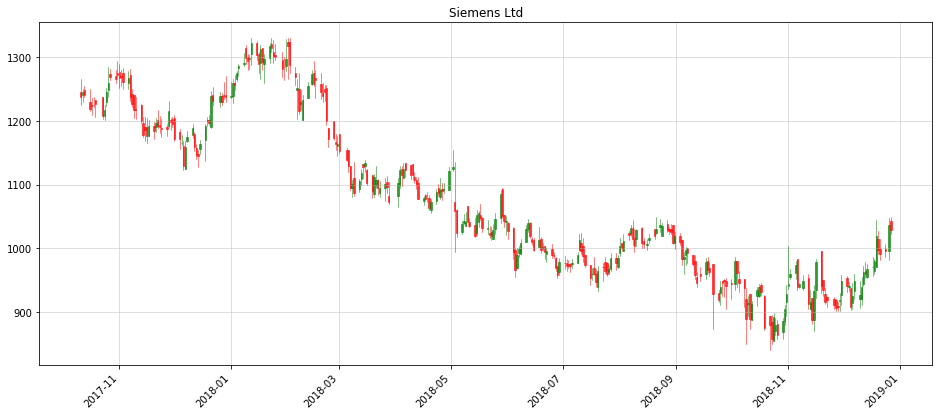

In [175]:
fig, ax = plt.subplots(figsize = (16,7))
fig.subplots_adjust(bottom=0.2)

quotes = zip(mdates.date2num(sample_data.index.to_pydatetime()),sample_data[u'Open Price'], 
                             sample_data[u'High Price'],sample_data[u'Low Price'], sample_data[u'Close Price'])
candlestick_ohlc(ax,quotes,width=0.75,colorup='g',colordown='red',alpha=0.6)
ax.xaxis_date()
ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title(STOCK_NAME)
plt.rc('axes', grid=True)
plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)
plt.show()

In [291]:
recent_data = data.iloc[-50:,:].copy()

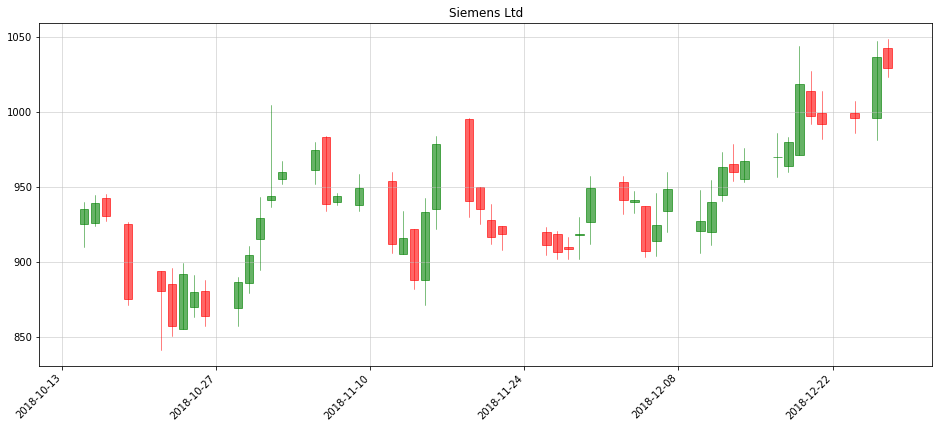

In [292]:
fig, ax = plt.subplots(figsize = (16,7))
fig.subplots_adjust(bottom=0.2)

quotes = zip(mdates.date2num(recent_data.index.to_pydatetime()),recent_data[u'Open Price'], 
                             recent_data[u'High Price'],recent_data[u'Low Price'], recent_data[u'Close Price'])
candlestick_ohlc(ax,quotes,width=0.75,colorup='g',colordown='red',alpha=0.6)
ax.xaxis_date()
ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title(STOCK_NAME)
plt.rc('axes', grid=True)
plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)
plt.show()

## High and Lows

In [176]:
def get_momentum_high_df(dataframe):
    peak_indices = get_peak_indices(dataframe)
    high_data = pd.DataFrame(data=[],index = dataframe.index[peak_indices],columns=['high_type'])
    high_data['high_type'] = 'momentum high'
    return high_data

def get_momentum_low_df(dataframe):
    trough_indices = get_trough_indices(dataframe)
    low_data = pd.DataFrame(data=[],index = dataframe.index[trough_indices],columns=['low_type'])
    low_data['low_type'] = 'momentum low'
    return low_data

In [177]:
momemtum_high_data = get_momentum_high_df(sample_data)
momentum_low_data = get_momentum_low_df(sample_data)

## Trend

In [178]:
trend_data = vasu.get_trend_data(sample_data)

In [179]:
vasu.get_ma_slope(sample_data['Close Price'],ma_period=20,slope_period=8)

0.41022301153839585

## Higher High and Lower Lows

In [180]:
higher_high_index = []
related_high_dates = []

for momentum_high_ts in momemtum_high_data.index:
    high_price = sample_data[u'High Price'].loc[momentum_high_ts]
    select_data = sample_data.loc[momentum_high_ts:]
    higher_high_data = select_data[select_data[u'Close Price'] > high_price][0:1]
    if len(higher_high_data) > 0:
        higher_high_index.append(higher_high_data.index[0])
        related_high_dates.append(momentum_high_ts)   

In [181]:
higher_high_data = pd.DataFrame(data=related_high_dates, index=higher_high_index,columns=['related high date'])
higher_high_data.index.name = 'Date'
higher_high_data['high_type'] = 'higher_high'

In [182]:
higher_high_data[:2]

,related high date,high_type
Date,,
2017-10-26,2017-10-13,higher_high
2017-10-25,2017-10-23,higher_high


In [183]:
lower_low_index = []
related_low_dates = []

for momentum_low_ts in momentum_low_data.index:
    low_price = sample_data[u'Low Price'].loc[momentum_low_ts]
    select_data = sample_data.loc[momentum_low_ts:]
    lower_low_data = select_data[select_data[u'Close Price'] < low_price][0:1]
    if len(lower_low_data) > 0:
        lower_low_index.append(lower_low_data.index[0])
        related_low_dates.append(momentum_low_ts)   

In [184]:
lower_low_data = pd.DataFrame(data=related_low_dates, index=lower_low_index,columns=['related low date'])
lower_low_data.index.name = 'Date'
lower_low_data['low_type'] = 'lower_low'

## Support and Resisence

In [272]:
resistance_prices = []
resistance_dilution = []
for lower_low_ts in lower_low_data.index:
    resistance_price = sample_data[u'High Price'].loc[lower_low_ts]
    resistance_prices.append(resistance_price)
    lower_low_swing_data = sample_data[lower_low_ts:][1:]
    resistance_dilution.append(len(lower_low_swing_data[lower_low_swing_data['Close Price'] > resistance_price]))
    
lower_low_data['resistance'] = resistance_prices
lower_low_data['resistance_dilution'] = resistance_dilution

In [293]:
lower_low_data

,related low date,low_type,resistance,resistance_dilution
Date,,,,
2017-10-23,2017-10-17,lower_low,1238.00,45
2017-11-13,2017-10-24,lower_low,1226.90,41
2017-12-06,2017-11-16,lower_low,1168.90,50
2017-12-01,2017-11-24,lower_low,1210.00,42
2018-03-07,2017-12-06,lower_low,1129.00,1
2018-03-07,2017-12-14,lower_low,1129.00,1
2018-02-07,2018-01-02,lower_low,1275.45,0
2018-02-05,2018-01-10,lower_low,1285.00,0
2018-02-06,2018-01-19,lower_low,1266.00,1


In [273]:
support_prices = []
support_violation = []
for higher_high_ts in higher_high_data.index:
    support_price = sample_data[u'Low Price'].loc[higher_high_ts]
    support_prices.append(support_price)
    higher_high_swing_data = sample_data[higher_high_ts:][1:]
    support_violation.append(len(higher_high_swing_data[higher_high_swing_data['Close Price'] < support_price]))
    
higher_high_data['support'] = support_prices
higher_high_data['support_violation'] = support_violation

## Special Candles

In [187]:
def is_hammer(row):
    candle_body = abs(row['Open Price'] - row['Close Price'])
    candle_length = row['High Price'] - row['Low Price']
    if (row['Close Price'] > row['Open Price']):
        candle_upper_shadow = row['High Price'] - row['Close Price']
    else:
        candle_upper_shadow = row['High Price'] - row['Open Price']
        
    if candle_body <= 0.3*candle_length and candle_upper_shadow <= 0.15*candle_length:
        return True
    else:
        return False

In [188]:
def is_inverse_hammer(row):
    candle_body = abs(row['Open Price'] - row['Close Price'])
    candle_length = row['High Price'] - row['Low Price']
    if (row['Close Price'] > row['Open Price']):
        candle_upper_shadow = row['High Price'] - row['Close Price']
    else:
        candle_upper_shadow = row['High Price'] - row['Open Price']
        
    if candle_body <= 0.3*candle_length and candle_upper_shadow > 0.65*candle_length:
        return True
    else:
        return False

In [189]:
hammer_data = sample_data[sample_data.apply(is_hammer,axis=1)].copy()
hammer_data['candle type'] = 'bullish pinbar'

In [190]:
invese_hammer_data = sample_data[sample_data.apply(is_inverse_hammer,axis=1)].copy()
invese_hammer_data['candle type'] = 'bearish pinbar'

In [191]:
pinbar_data = pd.concat([hammer_data,invese_hammer_data]).sort_index()

In [192]:
### Bullish Engulfing
bullish_engulfing_list = []
for ts, row in sample_data[:-1].iterrows():
    #first candle is negative
    if row[u'Close Price'] < row[u'Open Price']:
        #print(ts)
        next_open = sample_data[ts:][1:2][u'Open Price'].values[0]
        next_close = sample_data[ts:][1:2][u'Close Price'].values[0]
        next_high = sample_data[ts:][1:2][u'High Price'].values[0]
        next_low = sample_data[ts:][1:2][u'Low Price'].values[0]
        next_ts = sample_data[ts:][1:2].index.values[0]
        #second candle is positive
        if next_close > next_open:
            if next_close > row[u'Open Price'] and next_open < row[u'Close Price']:
                if next_high > row[u'High Price'] and next_low < row[u'Low Price']:
                    bullish_engulfing_list.append(sample_data[ts:][1:2].copy())
                    
if len(bullish_engulfing_list) > 0:
    bullish_engulfing_data = pd.concat(bullish_engulfing_list) 
else:
    bullish_engulfing_data = pd.DataFrame()
    
bullish_engulfing_data['candle type'] = 'bullish engulfing'  

In [193]:
### bearish Engulfing
bearish_engulfing_list = []
for ts, row in sample_data[:-1].iterrows():
    #first candle is positive
    if row[u'Close Price'] > row[u'Open Price']:
        next_open = sample_data[ts:][1:2][u'Open Price'].values[0]
        next_close = sample_data[ts:][1:2][u'Close Price'].values[0]
        next_high = sample_data[ts:][1:2][u'High Price'].values[0]
        next_low = sample_data[ts:][1:2][u'Low Price'].values[0]
        next_ts = sample_data[ts:][1:2].index.values[0]
        #second candle is negative
        if next_close < next_open:
            if next_close < row[u'Open Price'] and next_open > row[u'Close Price']:
                if next_high > row[u'High Price'] and next_low < row[u'Low Price']:
                    bearish_engulfing_list.append(sample_data[ts:][1:2].copy())

if len(bearish_engulfing_list) > 0:
    bearish_engulfing_data = pd.concat(bearish_engulfing_list)
else:
    bearish_engulfing_data = pd.DataFrame()
    
bearish_engulfing_data 
bearish_engulfing_data['candle type'] = 'bearish engulfing'  

In [194]:
engulfing_data = pd.concat([bearish_engulfing_data,bullish_engulfing_data]).sort_index()

## All Events

In [195]:
last_trend = trend_data[trend_data['trend'] != 'indeterminate']['trend'].tail(1).values[0]
last_ma_trend = vasu.get_ma_slope(sample_data[u'Close Price'],ma_period=20,slope_period=8)
print('stock trend is : %s and moving averages are trend is : %f'%(last_trend,last_ma_trend))

stock trend is : bullish and moving averages are trend is : 0.410223


In [196]:
event_data = []
signal_start_date = datetime.datetime(year=2018,month=12,day=15)
signal_end_date = datetime.datetime.now()

In [197]:
#highs and lows
momentum_high_select_data = momemtum_high_data.reset_index()[momemtum_high_data.reset_index()['Date'] > signal_start_date].set_index('Date')
for ts,row in momentum_high_select_data.iterrows():
    event_dict = {'event_ts' : ts, 'event_type' : row['high_type']}
    event_data.append(event_dict)

momentum_low_select_data = momentum_low_data.reset_index()[momentum_low_data.reset_index()['Date'] > signal_start_date].set_index('Date')
for ts,row in momentum_low_select_data.iterrows():
    event_dict = {'event_ts' : ts, 'event_type' : row['low_type']}
    event_data.append(event_dict)

In [198]:
#higher highs and lower lows
higher_high_select_data = higher_high_data.reset_index()[higher_high_data.reset_index()['Date'] > signal_start_date].set_index('Date')
for ts,row in higher_high_select_data.iterrows():
    event_dict = {'event_ts' : ts, 'event_type' : row['high_type'], 
                  'related_high_date' : row['related high date'], 'support' : row['support']}
    event_data.append(event_dict)
    
lower_low_select_data = lower_low_data.reset_index()[lower_low_data.reset_index()['Date'] > signal_start_date].set_index('Date')
for ts,row in lower_low_select_data.iterrows():
    event_dict = {'event_ts' : ts, 'event_type' : row['low_type'], 
                  'related_low_date' : row['related high date'], 'resistance' : row['resistance']}
    event_data.append(event_dict)    

In [199]:
#special candles
hammer_select_data = hammer_data.reset_index()[hammer_data.reset_index()['Date'] > signal_start_date].set_index('Date')
for ts,row in hammer_select_data.iterrows():
    event_dict = {'event_ts' : ts, 'event_type' : 'special candle', 'candle type' : 'pinbar'}
    event_data.append(event_dict) 

In [200]:
engulfing_select_data = engulfing_data.reset_index()[engulfing_data.reset_index()['Date'] > signal_start_date].set_index('Date')
for ts,row in engulfing_select_data.iterrows():
    event_dict = {'event_ts' : ts, 'event_type' : 'special candle', 'candle type' : row['candle type']}
    event_data.append(event_dict) 

In [201]:
pinbar_select_data = pinbar_data.reset_index()[pinbar_data.reset_index()['Date'] > signal_start_date].set_index('Date')
for ts,row in pinbar_select_data.iterrows():
    event_dict = {'event_ts' : ts, 'event_type' : 'special candle', 'candle type' : row['candle type']}
    event_data.append(event_dict) 

In [203]:
pd.DataFrame(event_data)

,candle type,event_ts,event_type,related_high_date,support
0,NaN,2018-12-19,momentum high,NaT,NaN
1,NaN,2018-12-26,momentum low,NaT,NaN
2,NaN,2018-12-19,higher_high,2018-09-06,971.05
3,NaN,2018-12-19,higher_high,2018-09-18,971.05
4,NaN,2018-12-19,higher_high,2018-10-03,971.05
5,NaN,2018-12-19,higher_high,2018-11-01,971.05
6,NaN,2018-12-19,higher_high,2018-11-19,971.05
7,bullish engulfing,2018-12-26,special candle,NaT,NaN


## Strategies

#### Bullish Continuation

In [285]:
# find latest lower low after scan date
lower_low_select_data = lower_low_data.reset_index()[lower_low_data.reset_index()['Date'] > signal_start_date].set_index('Date')
if len(lower_low_select_data) > 0:
    benchmark_date = lower_low_select_data[-1:].index.values[0]
    trade_window_data = sample_data.loc[benchmark_date:]
    benchmark_price = trend_data.loc[benchmark_date]['High Price']
    benchmark_trend = trend_data.loc[benchmark_date]['trend']
    benchmark_ma_trend = vasu.get_ma_slope(sample_data.loc[:benchmark_date][u'Close Price'],ma_period=20,slope_period=8)

    if benchmark_trend == 'bullish' and benchmark_ma_trend > 0.2:
        print('trend is bullish!')
        buy_signal_date = trade_window_data[trade_window_data['Close Price'] > benchmark_price][:1].index.values[0]
        print('buy signal at %s' % buy_signal_date)  
        stop_loss = trade_window_data.loc[buy_signal_date]['Low Price'] - 0.1
        buy_price = trade_window_data.loc[buy_signal_date]['High Price']*1.003
        risk = buy_price - stop_loss
        resistance_data = lower_low_data[lower_low_data['resistance_dilution'] < 1]['resistance'].sort_values()
        resistance_data['risk_reward'] = (resistance_data - buy_price)/risk
        print(resistance_data['risk_reward'])

#### Bullish Reversal

In [ ]:
# find latest lower low after scan date
higher_high_select_data = higher_high_data.reset_index()[higher_high_data.reset_index()['Date'] > signal_start_date].set_index('Date')
if len(higher_high_select_data) > 0:
    benchmark_date = higher_high_select_data[-1:].index.values[0]
    trade_window_data = sample_data.loc[benchmark_date:]
    benchmark_price = trend_data.loc[benchmark_date]['Low Price']
    benchmark_trend = trend_data.loc[benchmark_date]['trend']
    benchmark_ma_trend = vasu.get_ma_slope(sample_data.loc[:benchmark_date][u'Close Price'],ma_period=20,slope_period=8)

    if benchmark_trend == 'bullish' and benchmark_ma_trend > 0.2:
        print('trend is bullish!')
        first_sign_date = trade_window_data[trade_window_data['Close Price'] < benchmark_price][:1].index.values[0]
        first_sign_data = trade_window_data.loc[first_sign_date:][1:]
        second_sign_date = first_sign_data[first_sign_data['Close Price'] > benchmark_price][:1].index.values[0]
        second_sign_data = trade_window_data.loc[second_sign_date:][1:]
        sell_signal_date = second_sign_data[second_sign_data['Close Price'] < benchmark_price][:1].index.values[0]
        print('sell signal at %s' % sell_signal_date)  
        
        stop_loss = trade_window_data.loc[sell_signal_date]['High Price'] + 0.1
        sell_price = trade_window_data.loc[sell_signal_date]['Low Price']*0.997
        risk = stop_loss - sell_price
        support_data = higher_high_data[higher_high_data['support_violation'] < 1]['support'].sort_values()
        support_data['risk_reward'] = (sell_price - support_data)/risk
        print(support_data['risk_reward'])        